In [1]:
!{sys.executable} -m pip install s3fs -U
import sys
#!{sys.executable} -m pip install sagemaker -U
!{sys.executable} -m pip install sagemaker-experiments -U
!{sys.executable} -m pip install sagemaker==1.72.0 -U
#!pip install -U sagemaker --user

/bin/sh: 1: {sys.executable}: not found
Requirement already up-to-date: sagemaker-experiments in /opt/conda/lib/python3.7/site-packages (0.1.24)
Requirement already up-to-date: sagemaker==1.72.0 in /opt/conda/lib/python3.7/site-packages (1.72.0)


# Predict Paramters of Nucler Plant Operations
### (Multi-Output Regression)
# Contents
1. [Background](#Background)
2. [Data](#Data)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Feature Engineering](#Feature-Engineering)
    - [Fourier Transform](#Fourier-Transform)
    - [Aggregate Features](#Aggregate-Features)
5. [Trial 1](#Trial-1)
6. [Model Deployment and Testing](#Model-Deployment-and-Testing)
7. [Clean up](#Clean-up)
8. [Test Cases](#Test-Cases)
9. [Lambda Functions](#Lambda-Functions)
10. [End to End Architcture and Next Steps](#End-to-End-Architcture-and-Next-Steps)


## Background
Nuclear Powerplants are one of the significant energy generators for world-leading nations. It is some times considered as a 'clean energy' source. Atomic power plants heat water to produce steam. The steam is used to spin large turbines that generate electricity. Nuclear power plants use the heat produced during nuclear fission to heat water. Nuclear energy generation of the US itself is 99.6 million kilowatts as of April 2020. Active monitoring of the powerplant systems is required to maintain balance in the systems. Any symptoms of abnormal behavior will result in catastrophic reactions. The objective of the current project is to predict x-coordinate,y-coordinate, mass, and velocity from the vibration data. This model is useful for identifying and detecting early signs of faults. 

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re

import seaborn as sns 
import sklearn as sl
import scipy as sp
from numpy import save

from tqdm import tqdm
import sagemaker
from sklearn.model_selection import train_test_split
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import (rule_configs,
                                Rule,
                                DebuggerHookConfig)
from sagemaker.model_monitor import (DataCaptureConfig,
                                     DatasetFormat,
                                     DefaultModelMonitor)
from sagemaker.s3 import (S3Uploader,
                          S3Downloader)

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri
docker_image_name = get_image_uri(boto3.Session().region_name, 
                                  'xgboost',
                                  repo_version='0.90-2')

	get_image_uri(region, 'xgboost', '1.0-1').


In [5]:
from utils import (create_train_test_split,
                   generate_agg_feats,
                   fft_features,
                   plot_vibration_data)

## Data
The train data contains five attributes. The attribute id and time are self-explanatory. The acceleration parameters in the collider are labeled as S1, S2, S3, and S4. In this data, each id is corresponding to one training instance. The timestamp difference between each observation in id is four seconds, and it can be considered an equispaced time series data-set. For each id, there is a corresponding entry in the training targets data. There are 1050000 in the training data and 2800 entries. The training target contains 2800 entries for X, Y, M, and V. These are the prediction target, the collider parameters.

Unlike the traditional data-sets in Machine learning exercises, we can't jump into modeling immediately. The data should be further converted to an appropriate scientific format before approaching the problem. One of the widely adopted methods is to apply Fourier Transform before using any modeling techniques. Let's explore the data further to understand the same.

In [6]:
s3_bucket_name = 'nukeall'
s3_prefix = 'nuclear'

In [7]:
data_file = "train_features.csv"
data_target_file = "train_target.csv"

features = pd.read_csv(f"s3://{s3_bucket_name}/{s3_prefix}/{data_file}")
targets = pd.read_csv(f"s3://{s3_bucket_name}/{s3_prefix}/{data_target_file}")

In [8]:
features.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [9]:
targets.head()

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


## Exploratory Data Analysis

Unlike the traditional Machine Learning dataset, the vibration data is arranged by the observation id's. Each id contains approximately 375 observations, which is of time series in nature. Exploration and pre-processing of the data require specific requirements than the traditional space. Let's explore a set of observations from the data. 

In [10]:
features[features.id == 10]

,id,Time,S1,S2,S3,S4
3750,10,0.000000,0.00,0.000000,0.0,0.0
3751,10,0.000004,0.00,0.000000,0.0,0.0
3752,10,0.000008,0.00,0.000012,0.0,0.0
3753,10,0.000012,0.00,0.025942,0.0,0.0
3754,10,0.000016,0.00,-4.869326,0.0,0.0
...,...,...,...,...,...,...
4120,10,0.001480,-153924.80,-20263.540000,-260804.9,184858.2
4121,10,0.001484,-27967.33,9682.087000,-236084.6,296736.4
4122,10,0.001488,92564.70,28692.150000,-207750.6,409014.5
4123,10,0.001492,188116.90,37090.780000,-179889.7,496129.8


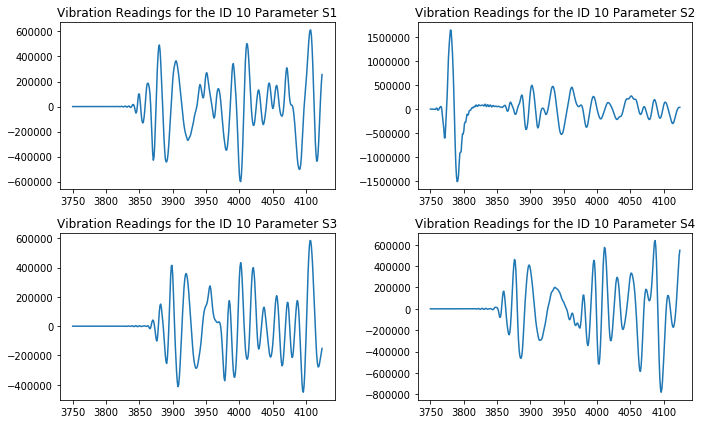

In [11]:
data_id = 10
plot_vibration_data(features[features.id == 10],
                    "Vibration Readings for the ID {0}".format(data_id))

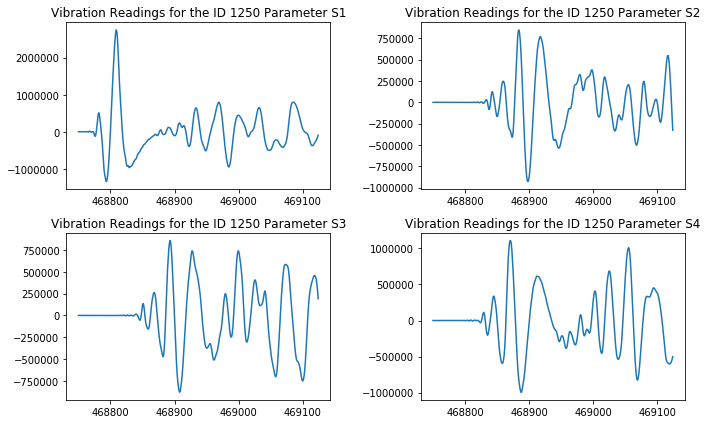

In [12]:
data_id = 1250
plot_vibration_data(features[features.id == 1250],
                    "Vibration Readings for the ID {0}".format(data_id))

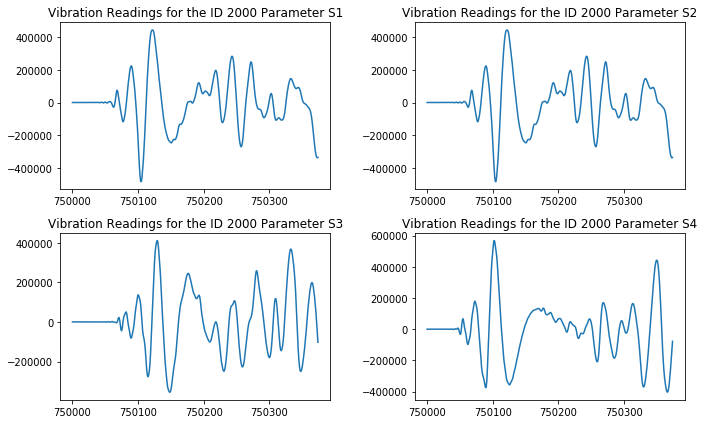

In [13]:
data_id = 2000
plot_vibration_data(features[features.id == 2000],
                    "Vibration Readings for the ID {0}".format(data_id))

## Feature Engineering
Each observation in the data consists of multiple records. We have to transform the data into a convenient format to apply any Machine Learning algorithm here. There are two prominent ways to create features from such data:

- Apply Fourier Transform 

- Aggregate the data

Let's try out these approaches in this example. 

### Fourier Transform
One of the prominent methods to approach signal data is to apply Fourier transformation in the data. The Fourier transformed data can be used for training a model.

## Aggregate Features

An alternative approach in feature engineering is to aggregate the features and compute key statistics such as mean, median, standard deviation, minimum value, and skew.

## Prapre Training Test and Validation Data

Due to the very nature of the training data splitting the training test and validation is tricky. We adopted a technique by dividing the training target data frame to train, test, validation set. The ids of each respective set are used to filter the training data to the three splits. 

In [14]:
ttv = create_train_test_split(targets)

In [15]:
test_target = ttv['test']

In [16]:
test_feat = features[features.id.isin(list(test_target.id))]
test_feat_fft = fft_features(test_feat)
test_feat_agg = generate_agg_feats(test_feat)

100%|██████████| 560/560 [00:01<00:00, 370.22it/s]


In [17]:
test_target.to_csv("data/test_tgt.csv", index=False)
save("data/test_fft.npy",test_feat_fft)
test_feat_agg.to_csv("data/test_feat.csv", index=False)

In [18]:
train_target = ttv['train']

In [19]:
train_feat = features[features.id.isin(list(train_target.id))]
train_feat_fft = fft_features(train_feat)
train_feat_agg = generate_agg_feats(train_feat)

100%|██████████| 1680/1680 [00:06<00:00, 258.75it/s]


In [20]:
train_target.to_csv("data/train_tgt.csv", index=False)
save("data/train_fft.npy",train_feat_fft)
train_feat_agg.to_csv("data/train_feat.csv", index=False)

In [21]:
val_traget = ttv['validate']

In [22]:
val_feat = features[features.id.isin(list(val_traget.id))]
val_feat_fft = fft_features(val_feat)
val_feat_agg = generate_agg_feats(val_feat)

100%|██████████| 560/560 [00:01<00:00, 376.54it/s]


In [23]:
val_traget.to_csv("data/val_tgt.csv", index=False)
save("data/val_fft.npy",val_feat_fft)
val_feat_agg.to_csv("data/val_feat.csv", index=False)

In [24]:
S3Uploader.upload('data/train_tgt.csv', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'train'))
S3Uploader.upload('data/train_fft.npy', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'train'))
S3Uploader.upload('data/train_feat.csv', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'train'))

's3://nukeall/nuclear/train/train_feat.csv'

In [25]:
S3Uploader.upload('data/test_tgt.csv', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'test'))
S3Uploader.upload('data/test_fft.npy', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'test'))
S3Uploader.upload('data/test_feat.csv', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'test'))

's3://nukeall/nuclear/test/test_feat.csv'

In [26]:
S3Uploader.upload('data/val_tgt.csv', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'val'))
S3Uploader.upload('data/val_fft.npy', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'val'))
S3Uploader.upload('data/val_feat.csv', 's3://{}/{}/{}'.format(s3_bucket_name, s3_prefix,'val'))

's3://nukeall/nuclear/val/val_feat.csv'

## Trial 1
In this trial, we will try to apply multi-output regression with GradientBoostingRegressor. 

In [27]:
sess = sagemaker.session.Session()

create_date = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
nuclear_experiment = Experiment.create(experiment_name="nuclear-reactor-1{}".format(create_date), 
                                              description="Using xgboost to predict reactor params", 
                                              sagemaker_boto_client=boto3.client('sagemaker'))

trial = Trial.create(trial_name="algorithm-mode-trial-{}".format(strftime("%Y-%m-%d-%H-%M-%S", gmtime())), 
                     experiment_name=nuclear_experiment.experiment_name,
                     sagemaker_boto_client=boto3.client('sagemaker'))

In [28]:
debug_rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
               Rule.sagemaker(rule_configs.overtraining()),
               Rule.sagemaker(rule_configs.overfit())
              ]

In [29]:
from sagemaker.sklearn.estimator import SKLearn
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [30]:
script_path = 'train_script.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    rules=debug_rules,
    hyperparameters={'ftype': 'fft'},
    framework_version="0.23-1")

In [31]:
train_s3 = "s3://nukeall/nuclear/train/"

In [32]:
sklearn.fit({'train': train_s3},
             wait=True,
            experiment_config={
                    "ExperimentName": nuclear_experiment.experiment_name, 
                    "TrialName": trial.trial_name,
                    "TrialComponentDisplayName": "Training",
                })

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2020-08-13-22-18-17-678


2020-08-13 22:18:18 Starting - Starting the training job...
2020-08-13 22:18:45 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*       Overtraining: InProgress        
*            Overfit: InProgress        
*
****************************************
.........
2020-08-13 22:20:06 Starting - Preparing the instances for training......
2020-08-13 22:21:14 Downloading - Downloading input data...
2020-08-13 22:21:49 Training - Downloading the training image...
2020-08-13 22:22:09 Training - Training image download completed. Training in progress.2020-08-13 22:22:10,473 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-08-13 22:22:10,474 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-13 22:22:10,484 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-08-13 22:22:10,849 sagemaker-training-tool

## Model Deployment and Testing

We will use the test FFT features to generate some payload to the model endpoint to test.

In [33]:
data_capture_prefix = '{}/datacapture_1'.format(s3_prefix)

endpoint_name = "demo-nuke-reactor-new" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName = {}".format(endpoint_name))

EndpointName = demo-nuke-reactor-new2020-08-13-22-23-00


In [34]:
sklp = sklearn.deploy(initial_instance_count=1,
                      instance_type='ml.m4.xlarge',
                      endpoint_name=endpoint_name,
                      data_capture_config=DataCaptureConfig(enable_capture=True,
                                                            sampling_percentage=100,
                                                            destination_s3_uri='s3://{}/{}'.format(s3_bucket_name,
                                                                                                   data_capture_prefix))
                           )

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2020-08-13-22-18-17-678
INFO:sagemaker:Creating endpoint with name demo-nuke-reactor-new2020-08-13-22-23-00


-------------------!

In [35]:
from sagemaker.predictor import csv_serializer
from sagemaker.predictor import (numpy_deserializer,
                                 npy_serializer
                                )
sklp.content_type = 'application/x-npy'
sklp.serializer = npy_serializer
sklp.deserializer = numpy_deserializer

In [38]:
for idx,sample in enumerate(test_feat_fft[:10]):
    pred = sklp.predict(np.asarray([test_feat_fft[idx]]))
    print(pred)
    time.sleep(0.5)

[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]
[[400. 300. 175.   1.]]


## Clean up

In [37]:
def cleanup(experiment):
    '''Clean up everything in the given experiment object'''
    for trial_summary in experiment.list_trials():
        trial = Trial.load(trial_name=trial_summary.trial_name)
        
        for trial_comp_summary in trial.list_trial_components():
            trial_step=TrialComponent.load(trial_component_name=trial_comp_summary.trial_component_name)
            print('Starting to delete TrialComponent..' + trial_step.trial_component_name)
            sm.disassociate_trial_component(TrialComponentName=trial_step.trial_component_name, TrialName=trial.trial_name)
            trial_step.delete()
            time.sleep(1)
         
        trial.delete()
    
    experiment.delete()

#cleanup(nuclear_experiment)

## Test Cases

Test cases for the utils script are located in the tests folder. The notebook Run_testCases.ipynb can be used to run the test cases.

## Lambda Functions
I created a sample lambda to invoke an endpoint. The lambda name is "nukelambda" (not fully tested).

## End to End Architcture and Next Steps
To operationalize the model in production scenarios, we have to leverage multiple AWS technology components. High-level considerations are listed here:

- Data Ingestion to AWS (From Reactor) - AWS IoT Services

- Data Storage - S3 and RDS.  S3 will be landing zone and RDS (PostgreSQL) for structured data.

- Model Rest APIS - AWS Lambda
- Dashboard - Quicksight
